# Reset networks - Topography for MNIST
**Objective**

Demonstrate the emergence of topography for number classification - MNIST

**Means**

Reset network <br>
MNIST dataset <br>

<img src = 'https://github.com/THANNAGA/Reset-Networks/blob/main/Topography%20for%20mnist/reset_archi_gene_mnist.png?raw=true' width=700px>


*Figure 1.(A) Reset Networks approach the visual cortex as a sequence of levels that realize different topographic spaces. Each level consists in a grid of deep neural networks sharing the entire input from the level below. The output of the grid then becomes the input to the grid of networks at the next level.**(B)** A Reset network with 2 levels trained on the QMNIST dataset.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
import time
import numpy as np
from numpy.ma import masked_array
from scipy import ndimage
from scipy.signal import convolve2d as conv
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import sys, math
import pandas as pd
from sklearn.utils import shuffle
import cv2

!pip install einops
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/')
from vit_pytorch import ViT, ViT_rec
from resnet import resnetSmall, resnet18, resnet34, resnet50, resnet101, resnet152 
from resnet_CIFAR10 import resnet20, hresnet20reg

In [3]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelname = 'ResetNumber4'#'ResNet20'#'ResetNumber8'
dataset = 'MNIST'
train_batchsize = 500
test_batchsize = 500
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
use_cuda = True
gridsize = 1
n_classes1 = 8*8#8*8#32*32#400#36#100
n_classes = 10
lrate = 0.001
drop_rate = 0.5
input_channels = 1
load_model = False
load_submodels = False
epochs = 10
num_workers=1


Transforms for data augmentation

In [5]:
augment_data = False
if augment_data: 
    transform = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    
    transform_w = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0, 0, 0), (1, 1, 1))])
else: 
    transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    transform_w = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0, 0, 0), (1, 1, 1))])

## Load MNIST

In [6]:
transform = transforms.Compose(
      [transforms.Resize(32),
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])
  
  #!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
  #!tar -zxvf MNIST.tar.gz
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.QMNIST(root='./data', train=True,
                                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize,
                                            shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.QMNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize,
                                          shuffle=False, num_workers=1)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_total = [np.sum(trainset.targets.numpy()[:,0] == i) for i in range(10)]
weights = torch.Tensor(np.max(class_total)/np.array(class_total))
print ('train class weights:', weights)

print ('QMNIST loaded')

train class weights: tensor([1.1383, 1.0000, 1.1316, 1.0997, 1.1541, 1.2437, 1.1392, 1.0761, 1.1523,
        1.1333])
QMNIST loaded


Reality check

classes[index], mean: 0 0.023418263
classes[index], mean: 0 0.11519467
classes[index], mean: 0 0.040805925
classes[index], mean: 3 -0.1697944
classes[index], mean: 2 0.117597446


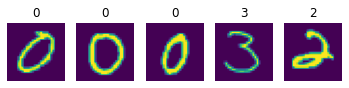

In [7]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
for i in np.arange(5):
  index = int(labels[i].numpy())
  plt.subplot(1,5,i+1)
  plt.title(classes[index])
  plt.axis('off')
  im = images[i].squeeze().numpy()
  plt.imshow(im)
  print ('classes[index], mean:', classes[index], np.mean(im))
plt.savefig('MNIST_10.png', dpi = 300)
plt.show()

## Model

In [8]:
# Reset network for QMNIST
class Reset(nn.Module):
  def __init__(self, input_channels=1, h1_1=400, gridsize=8, n_classes1=16, n_classes2=10, drop_rate=0.2):
    super(Reset, self).__init__()
    self.gridsize = gridsize
    self.n_classes1 = n_classes1
    self.sqrt_n_classes1 = int(n_classes1**0.5)
    self.Nest1 = nn.ModuleList([resnet20(num_channels=input_channels, num_classes=n_classes1) for i in np.arange(self.gridsize**2)])
    self.Classifier = resnet20(num_channels=1, num_classes=n_classes2)
    self.BN0 = nn.BatchNorm2d(num_features = 1)
    self.dropout = nn.Dropout(drop_rate)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
	
  def forward(self, x):
    level1 = [self.Nest1[i](x) for i in np.arange(self.gridsize**2)] #process input through all networks at level 1
    level1 = torch.stack(level1, dim=0)
    level1 = level1.permute(1,2,0)
    # reshape by patch (nested list comprehension probably more elegant)
    to_cat = []
    for j in np.arange(self.gridsize):
      to_cat += [torch.cat([level1[:,:,i].reshape(-1, 1, self.sqrt_n_classes1, self.sqrt_n_classes1) for i in np.arange(j*self.gridsize, (j+1)*self.gridsize)],3)]
    grid = torch.cat(to_cat, 2)
    #grid = self.sigmoid(grid)
    grid = self.tanh(grid)
    grid = self.dropout(grid)
    grid = self.BN0(grid)
    out_c = self.Classifier(grid)
    return grid, out_c

In [9]:
def load_Model(checkpointpath=None, modelname=None, dataset=None, load_model=False,
               input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes):

  if 'Reset' in modelname:
    net = Reset(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Reset network for QMNIST loaded')

  if 'ResNet20' in modelname:
    net = hresnet20reg(num_channels=input_channels, num_classes=n_classes)
    print ('ResNet20 loaded')

  model_total_params = sum(p.numel() for p in net.parameters())
  print('==> Model built. The model has ',model_total_params,'total parameters, and ',n_classes,'classes')

  if load_model:
    #load the model
    state = torch.load(checkpointpath + modelname + dataset + 'best_ckpt.t7')
    keys = list(state['net'].keys()); print ('This network had', len(keys),'stored sets of parameters')
    if 'module.' in keys[0]:
      for name in keys:
        state['net'][name[7:]] = state['net'].pop(name)
    net.load_state_dict(state['net'])
    print ('Pretrained weights loaded')

  if load_submodels:
    #load pretrained submodel
    pretrained_dict = submodel.state_dict()
    
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys (remove key for last dense layer)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k is not 'fc2'}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(pretrained_dict)
  
  return net

net = load_Model(checkpointpath=checkpointpath, modelname=modelname, load_model=load_model)

ResNet20 loaded
==> Model built. The model has  269434 total parameters, and  10 classes


# Training

Parallel computing

In [10]:
# Parallel computing
device = torch.device("cuda" if use_cuda else "cpu")
print ('device:', device)
net.to(device)
net = torch.nn.DataParallel(net)
weights = weights.to(device)
GPUcount = torch.cuda.device_count()
if GPUcount == 0:
  print ('No GPU available.')
if GPUcount == 1:
  print ('One GPU available.')
if GPUcount > 1:
  print (GPUcount, 'GPUs are available.')
print ('GPU type:', torch.cuda.get_device_name())

device: cuda
One GPU available.
GPU type: Tesla P100-PCIE-16GB


In [11]:
Adam=True
if Adam:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters(), lr=lrate)

In [12]:
Sgd=False
if Sgd:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Testing:

In [13]:
def test(net):
  net.eval()
  start = time.time()
  net.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)
          grid, outputs = net(inputs)
          testloss = criterion(outputs, targets).item()
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == targets).float().sum()
          total += labels.size(0)
  testacc = (100*correct/total).cpu().numpy()
  print('test accuracy of the network on ',total,'test images:',testacc)

  end = time.time()
  print('Test time:', time.strftime('%H:%M:%S', time.gmtime(end-start)))
  print('n')

  return grid, testacc

Compute grid responses and output accuracies for all categories

In [14]:
def compute_class_grid2(grid, epoch=0, verbose=False):
  n = len(classes)
  if modelname == 'ResNet20':
    gn, gh = grid.shape
    gc = 1
    gs = int(gh**0.5)
  else:
    gn, gc, gs, gs = grid.shape
  print ('gn, gc, gs, gs', gn, gc, gs, gs)
  class_correct = list(0. for i in np.arange(n))
  class_total = list(0. for i in np.arange(n))
  class_grid = np.ones((n, gs, gs))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          grid, outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)

          grid_data = grid.cpu().numpy().squeeze()
          if modelname == 'ResNet20':
            grid_data = np.reshape(grid_data, (-1, gs, gs))

          for i, label in enumerate(labels):
              label = int(label.cpu().numpy())
              if gc > 1:
                class_grid[label] += np.mean(grid[i], axis=0)
              else:
                class_grid[label] += grid_data[i]
              if epoch == 0:
                class_grid[label] += np.random.rand(gs, gs)*1e-3 #This trick avoids retruning a single argmax in case of equal values.
              class_correct[label] += predicted[i].item()
              class_total[label] += 1
  class_acc = np.zeros(n)
  for i in np.arange(n):
      class_acc[i] = 100 * class_correct[i] / class_total[i]
      if class_total[i] > 0:
        class_grid[i] = class_grid[i]/class_total[i]
      if verbose:
        print('%3d Accuracy of %5s : %2d %% (%5d / %5d)' % (i, classes[i], class_acc[i], class_correct[i], class_total[i]))
  return class_acc, class_grid
  
go_compute_class_grid2 = False
if go_compute_class_grid2:
  class_acc, class_grid = compute_class_grid2(grid, verbose=True)

Training

In [15]:
start = time.time()
e_start = time.time()
ltrain, ltest = len(trainloader), len(testloader)
print ('number of mini-batches for training:', ltrain)
print ('mini-batch size:', train_batchsize)
print ('total number of training exemplars:', ltrain*train_batchsize)
print ('\nnumber of mini-batches for testing:', ltest)
print ('mini-batch size:', test_batchsize)

if load_model:
  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  last_epoch = len(test_acc_history)
  bestacc = np.max(test_acc_history)
  print ('saved metrics loaded')
else:
  test_acc_history = []
  class_acc_history = []
  class_grid_history = []
  last_epoch = 0
  bestacc = 0

test_every = ltrain//2
#test_every = 2*ltrain   #never test
print_every = ltrain//20
print ('we will test every:', test_every, 'mini-batches, meaning, every',test_every*train_batchsize,'training exemplars.')

# Initial testing before training.
grid, testacc = test(net)
test_acc_history += [testacc]
class_acc, class_grid = compute_class_grid2(grid, verbose=False)
class_acc_history += [class_acc]
class_grid_history += [class_grid]
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)

# Start training
net.train()
for epoch in np.arange(last_epoch + epochs): 
    print ('Epoch:', epoch) 
    running_loss = 0.0
    running_lossAuto = 0.0
    running_lossClass = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #print ('labels.size()', labels.size())

        optimizer.zero_grad()
        grid, outputs = net(inputs)
        #print(outputs.size())
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i != 0) & (i % print_every == 0):    # print
          print ('[batch %3d] loss:%.3f' % (i, loss.item()))

        if (i != 0) & (i % test_every == 0):    # test 
            e_end = time.time()
            print('\n\nTraining time:', time.strftime('%H:%M:%S', time.gmtime(e_end - e_start)))
            e_start = time.time()

            closs = running_loss / test_every
            print('[%d, %5d] loss:%.3f' % (epoch + 1, i + 1, closs))

            running_loss = 0.0
            _, testacc = test(net)
            test_acc_history += [testacc]
            class_acc, class_grid = compute_class_grid2(grid, epoch=epoch, verbose=False)
            class_acc_history += [class_acc]
            class_grid_history += [class_grid]
            np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
            net.train()

            if testacc > bestacc:
              print ('saving as best model')
              state = {'net': net.state_dict(),}
              torch.save(state, checkpointpath + modelname + dataset + 'best_ckpt.t7')
              bestacc = testacc
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
end = time.time()
print('Done training. Total training time:')
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

number of mini-batches for training: 120
mini-batch size: 500
total number of training exemplars: 60000

number of mini-batches for testing: 120
mini-batch size: 500
we will test every: 60 mini-batches, meaning, every 30000 training exemplars.
test accuracy of the network on  60000 test images: 9.801667
Test time: 00:00:07
n
gn, gc, gs, gs 500 1 8 8
Epoch: 0
[batch   6] loss:2.153
[batch  12] loss:1.997
[batch  18] loss:1.912
[batch  24] loss:1.834
[batch  30] loss:1.778
[batch  36] loss:1.749
[batch  42] loss:1.703
[batch  48] loss:1.661
[batch  54] loss:1.617
[batch  60] loss:1.597


Training time: 00:00:19
[1,    61] loss:1.870
test accuracy of the network on  60000 test images: 83.041664
Test time: 00:00:07
n
gn, gc, gs, gs 500 1 8 8
saving as best model
[batch  66] loss:1.567
[batch  72] loss:1.550
[batch  78] loss:1.541
[batch  84] loss:1.520
[batch  90] loss:1.506
[batch  96] loss:1.510
[batch 102] loss:1.497
[batch 108] loss:1.497
[batch 114] loss:1.485
Epoch: 1
[batch   6] los

## Various tests

class_grid_history.shape (11, 10, 32, 32)


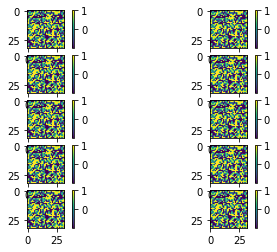

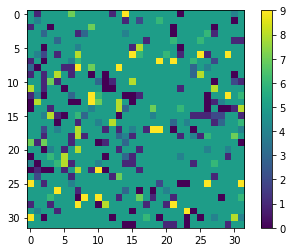

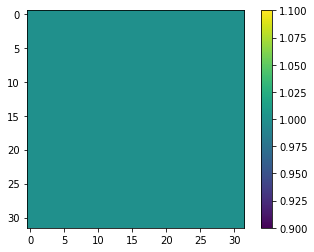

In [4]:
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  print ('class_grid_history.shape',class_grid_history.shape)
  for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(class_grid_history[0,i])
    plt.colorbar()
  plt.show()
  #A = np.sum(class_grid_history[0], axis=0)
  A = class_grid_history[0,0]
  B = class_grid_history[0,1]
  if np.array_equal(A,B):
    print ('all the same')
  vis = np.argmax(class_grid_history[0],axis=0)
  plt.imshow(vis)
  plt.colorbar()
  plt.show()
  # visualize how many elements the argmax returns at each location of the grid
  for i in range(32):
     for j in range(32):
       tube = class_grid_history[0,:,i,j]
       vis[i,j] = len(np.flatnonzero(tube == np.max(tube)))
  plt.imshow(vis)
  plt.colorbar()
  plt.show()

In [17]:
# Test model
grid, testacc = test(net)
print ('testacc=', testacc)
print ('grid shape:', grid.size())
grid = grid.detach().cpu().numpy()
plt.imshow(np.mean(grid[:,0,:,:], axis=0));plt.colorbar();plt.show()
print ('grid min:',np.min(grid[:,0,:,:]))
print ('grid mean:',np.mean(grid[:,0,:,:]))
print ('grid max:',np.max(grid[:,0,:,:]))

test accuracy of the network on  60000 test images: 98.25667
Test time: 00:00:07
n
testacc= 98.25667
grid shape: torch.Size([500, 64])


IndexError: ignored

## Number topography

In [18]:
"""
def topo(data, lc=9, pad=1):
  lx, ly = data.shape
  # create a copy padded with -1
  topo_index = 0
  map_below = -1*np.ones((lx+2*pad,ly+2*pad))
  map_below[pad:-pad, pad:-pad] = np.copy(data)
  data = masked_array(data, data < 0)
  map_below = masked_array(map_below, map_below < 0)
  count = 0
  for i in range(lx):
    for j in range(ly):
      #compute similarity between each unit and its neighbor.
      if data[i,j] != -1:
        lo = map_below[i-pad : i+pad+1, j-pad : j+pad+1]
        n = np.sum(lo>-1)
        if n != 0:
          topo_index += 1 - np.mean(np.abs(lo - data[i,j]))/(lc)
          count += 1
  topo_index = topo_index/count
  return topo_index
"""
def topo(data):
  #topo_index = np.mean(ndimage.sobel(data)) # the more variations on the sobeled map, the less the neighbors are the same, the less topography.
  #topo_index = np.mean(data - gaussian_filter(data, sigma = 1))
  filter = (-1/8)*np.ones((3, 3));filter[0,0]=1
  d = np.mean(ndimage.convolve(data, filter))
  dz = np.mean(ndimage.convolve(data, (1/8)*np.ones((3, 3))))
  if d != 0:
    topo_index = 1/d # topography == same neighbors ==> more canceling ==> low mean ==> high inverse of mean
  else:
    topo_index = dz
  return topo_index

def clustering_index2(data, threshold=0.85, connectivity=4):
  den_index = np.sum(data)
  data = (data > threshold).astype(np.uint8)
  # Thresholding
  ret, thresh = cv2.threshold(data,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # Choose 4 or 8 for connectivity type
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  clu_index = np.mean(stats[1:,-1])
  if math.isnan(clu_index):
    clu_index = 1 #minimal cluster size
  topo_index = topo(data)
  return num_labels, labels, clu_index, topo_index

def compute_pipeline2(select1, select2, T = 1, connectivity = 8, gf_sigma=0, show=False):

  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  gf_sigma = 0#.5
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index
  _, _, clu_index,topo_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  # compute control clustering index
  clu_index_ctrl = 0
  topo_index_ctrl = 0
  power = 20
  for k in range(10):
    dmapshuf = np.ravel(np.copy(dmap))
    np.random.shuffle(dmapshuf)
    dmapshuf = np.reshape(dmapshuf, dmap.shape)
    _, _, ctrl_clu, ctrl_topo = clustering_index2(dmapshuf, threshold=T, connectivity=connectivity)
    clu_index_ctrl += ctrl_clu
    topo_index_ctrl += ctrl_topo
  clu_index_ctrl = clu_index_ctrl/float(power)
  topo_index_ctrl = topo_index_ctrl/float(power)

  # return variables
  targets_data = dmap #> T

  density = np.sum(smean1)
  if show:
    plt.figure(figsize=(10,10))
    plt.subplot(141);plt.imshow(mean1);plt.title('mean1');plt.axis('off')
    plt.subplot(142);plt.imshow(mean2);plt.title('mean2');plt.axis('off')
    plt.subplot(143);plt.imshow(dmap);plt.title('dprimes 1-2');plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.subplot(144);plt.imshow(dmap>T);plt.title('clustering:'+str(clu_index)[:5]);plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.show()
    return stop_error
  
  return targets_data, clu_index, clu_index_ctrl, topo_index, topo_index_ctrl, density

def compute_save_metrics2(modelname=None, dataset=None, T=2, S=0, nopref=False):
  # load data history
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  print ('class_grid_history.shape',class_grid_history.shape)

  # initialize arrays 
  n_epochs,_,x,y = np.shape(class_grid_history)
  n_classes = lc
  print ('n_epochs,n_classes,x,y', n_epochs,n_classes,x,y)
  target_maps_history = np.zeros((n_epochs, n_classes, x, y))
  clustering_history = np.zeros((n_epochs, n_classes))
  clustering_history_ctrl = np.zeros((n_epochs, n_classes))
  topo_history = np.zeros((n_epochs, n_classes))
  topo_history_ctrl = np.zeros((n_epochs, n_classes))
  density_history = np.zeros((n_epochs, n_classes))
  target_acc_history = np.zeros((n_epochs, n_classes))

  # setting parameters for sensitivity and clustering analysis
  connectivity = 4

  # consider a contrast between two sets of classes, here animals vs objects
  
  sets1 = np.arange(lc)
  sets2 = np.array([[j for j in sets1 if i != j] for i in sets1])
  
  # compute
  for epoch in range(n_epochs):
    print ('analyzing data from epoch', epoch)
    for cat, (set1, set2) in enumerate(zip(sets1, sets2)):
      #print ('cat', cat)
      #print ('set1', set1)
      #print ('set2', set2)
      select1 = class_grid_history[epoch, set1]
      select1 = np.expand_dims(select1, axis=0) #easier to expand dim here this way, for clustering index.
      select2 = class_grid_history[epoch, set2]
      
      targets_data, clustering, clustering_ctrl, topo, topo_ctrl, density = compute_pipeline2(select1, select2, T = T, connectivity = connectivity, gf_sigma=S, show=False)
      target_maps_history[epoch, cat] = targets_data
      clustering_history[epoch, cat] = clustering
      clustering_history_ctrl[epoch, cat] = clustering_ctrl
      topo_history[epoch, cat] = topo
      topo_history_ctrl[epoch, cat] = topo_ctrl
      density_history[epoch, cat] = density
      target_acc_history[epoch, cat] = np.mean(class_acc_history[epoch,set1])

  # create label maps. This makes a lot of sense for numerosity, since we've got a clear number line.
  
  if nopref:
    # label -1 will stand for "no preference", when all d-primes are below thresholds
    # we achieve that by concatenating a no preference map before the d-prime maps, filled with a high value.
    # then we remove 1 to all the labels.
    label_maps_history = np.zeros((n_epochs,x,y))
    for epoch, target_maps in enumerate(target_maps_history):
      thres_data = (target_maps<T)
      #print ('thres_data.shape',thres_data.shape)
      indices_no_pref = (np.sum(thres_data, axis=0) == lc)
      #print ('indices_no_pref.shape',indices_no_pref.shape)
      #print ('indices_no_pref', indices_no_pref)
      #plt.imshow(indices_no_pref);plt.show()
      #print ('indices_no_pref', indices_no_pref)
      no_pref = 100*indices_no_pref
      #plt.imshow(no_pref);plt.show()
      no_pref = np.expand_dims(no_pref, axis=0)
      #print ('no_pref.shape',no_pref.shape)
      target_maps = np.concatenate((no_pref, target_maps))
      #print ('target_maps.shape',target_maps.shape)
      label_maps = np.argmax(target_maps, axis=0) - 1
      #print ('label_maps.shape, min, max',label_maps.shape, label_maps.min(), label_maps.max())
      #plt.imshow(label_maps);plt.colorbar();plt.show()
      label_maps_history[epoch] = label_maps
    masked_array(label_maps_history, label_maps_history < 0)
    #plt.imshow(masked_array(label_maps, label_maps < 0));plt.colorbar();plt.show()

    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)
    np.save(checkpointpath + modelname + dataset + 'topo_history.npy', topo_history)
    np.save(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy', topo_history_ctrl)

  else:
    label_maps_history = np.argmax(target_maps_history, axis=1)
    
    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'density_history.npy', density_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)
    np.save(checkpointpath + modelname + dataset + 'topo_history.npy', topo_history)
    np.save(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy', topo_history_ctrl)

In [19]:
def animate_numerosity(T=None, S_map = None, save=True, nopref=False):
  import numpy as np
  from numpy.ma import masked_array
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML
  from scipy.stats import describe

  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  target_acc_history = np.load(checkpointpath + modelname + dataset + 'target_acc_history.npy')
  density_history = np.load(checkpointpath + modelname + dataset + 'density_history.npy')
  clustering_history = np.load(checkpointpath + modelname + dataset + 'clustering_history.npy')
  clustering_history_ctrl = np.load(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy')
  topo_history = np.load(checkpointpath + modelname + dataset + 'topo_history.npy')
  topo_history_ctrl = np.load(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy')
  if nopref:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy')
  else:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history.npy')

  print ('label_maps_history.shape, min, max',label_maps_history.shape, label_maps_history.min(), label_maps_history.max())
  epoch, x, y = label_maps_history.shape

  target_acc_history = np.median(target_acc_history, axis=1)
  density_history = np.median(density_history, axis=1)
  clustering_history = np.median(clustering_history, axis=1)
  clustering_history_ctrl = np.median(clustering_history_ctrl, axis=1)
  topo_history = np.median(topo_history, axis=1)
  topo_history_ctrl = np.median(topo_history_ctrl, axis=1)
  
  print ('test_acc_history.shape', test_acc_history.shape)
  print ('target_acc_history.shape', target_acc_history.shape)
  print ('density_history.shape', density_history.shape)
  print ('label_maps_history.shape', label_maps_history.shape)
  print ('clustering_history.shape', clustering_history.shape)
  print ('clustering_history_ctrl.shape', clustering_history_ctrl.shape)
  print ('topo_history.shape', topo_history.shape)
  print ('topo_history_ctrl.shape', topo_history_ctrl.shape)
  print ('topo_history', topo_history)
  print ('topo_history_ctrl', topo_history_ctrl)
  print ('clustering_history', clustering_history)
  print ('clustering_history_ctrl', clustering_history_ctrl)
  print ('describe(clustering_history)', describe(np.ravel(clustering_history)))
  print ('describe(density_history)', describe(np.ravel(density_history)))

  epochs = np.arange(epoch)
  nans = np.nan*np.zeros(epoch)
  acc_lines, clu_lines, clu_ctrl_lines, topo_lines, topo_ctrl_lines, den_lines = [[]], [[]], [[]], [[]], [[]], [[]]

  titles = classes
  l = len(titles)

  fig = plt.figure(figsize=(12, 12)) 
  ncols, nrows = 15, 15
  gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=2, hspace=10)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
  # Add axes which can span multiple grid boxes
  ax0 = fig.add_subplot(gs[:3, :5])
  ax1 = fig.add_subplot(gs[:3, 5:10])
  ax2 = fig.add_subplot(gs[:3, 10:15])
  ax3 = fig.add_subplot(gs[3:, :15])

  #plt.suptitle(modelname+' '+dataset, size=25)
  ax0.set_title('Test accuracy', size=20)
  ax0.set_xlabel('Epochs', size=13) 
  ax0.set_xlim(0, epoch+1)
  
  #ax1.set_title('clustering index', size=20)
  ax1.set_title('Cluster size', size=20)
  ax1.set_xlabel('Epochs', size=13)
  ax1.set_xlim(0,epoch+1)
  
  #ax2.set_title('density index', size=20)
  ax2.set_title('Neighbor similarity', size=20)
  ax2.set_xlabel('Epochs', size=13)
  ax2.set_xlim(0,epoch+1)
  
  ax3.set_title('Epoch 0', size=20, y=-0.07)
  ax3.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  ax3.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  MAX = np.max(label_maps_history)
  smooth = True
  sigma_curves = 1
  if smooth:
    target_acc_history = ndimage.gaussian_filter1d(target_acc_history, sigma_curves, axis=0)
    clustering_history = ndimage.gaussian_filter1d(clustering_history, sigma_curves, axis=0)
    clustering_history_ctrl = ndimage.gaussian_filter1d(clustering_history_ctrl, sigma_curves, axis=0)
    topo_history = ndimage.gaussian_filter1d(topo_history, sigma_curves, axis=0)
    topo_history_ctrl = ndimage.gaussian_filter1d(topo_history_ctrl, sigma_curves, axis=0)
    density_history = ndimage.gaussian_filter1d(density_history, sigma_curves, axis=0)
  
  rescale = True
  min_acc, max_acc = np.min(target_acc_history), np.max(target_acc_history)
  min_clu = np.min((np.min(clustering_history), np.min(clustering_history_ctrl))) 
  max_clu = np.max((np.max(clustering_history), np.max(clustering_history_ctrl)))
  min_topo = np.min((np.min(topo_history), np.min(topo_history_ctrl)))
  max_topo = np.max((np.max(topo_history), np.max(topo_history_ctrl)))
  min_den, max_den = np.min(density_history), np.max(density_history)
  if rescale:
    target_acc_history = 100*(target_acc_history - min_acc) / (max_acc - min_acc)
    clustering_history = (clustering_history - min_clu) / (max_clu - min_clu)
    clustering_history_ctrl = (clustering_history_ctrl - min_clu) / (max_clu - min_clu)
    topo_history = (topo_history - min_topo) / (max_topo - min_topo)
    topo_history_ctrl = (topo_history_ctrl - min_topo) / (max_topo - min_topo)
    density_history = (density_history - min_den) / (max_den - min_den)
    ax0.set_ylim(0,105) 
    ax1.set_ylim(0,1.05)
    ax2.set_ylim(0,1.05)
  else:
    ax0.set_ylim(np.floor(min_acc), np.ceil(max_acc)) 
    ax1.set_ylim(0, np.ceil(max_clu))
    ax2.set_ylim(min_topo, np.ceil(max_topo))
    #ax2.set_ylim(0, 100)
    #ax2.set_ylim(np.floor(min_den), np.ceil(max_den))

  max = 9; min = 0
  cmap = plt.get_cmap('gist_rainbow', max+1-min)
  color = 'black'
  # plot: accuracy
  acc_lines[0], = ax0.plot([], [], color=color, lw=2)
  # plot: clustering
  clu_lines[0], = ax1.plot([], [], color=color, label='normal', lw=2)
  # plot: clustering ctrl
  clu_ctrl_lines[0], = ax1.plot([], [], color='gray', label='shuffled', lw=2);ax1.legend(frameon=False)
  # plot: topo
  topo_lines[0], = ax2.plot([], [], color=color, lw=2)
  # plot: topo ctrl
  topo_ctrl_lines[0], = ax2.plot([], [], color='gray', label='shuffled', lw=2)#;ax1.legend(frameon=False)
  # plot: density
  #den_lines[0], = ax3.plot([], [], color=color, lw=2)
  # plot: common map
  data = label_maps_history[0]
  images = ax3.imshow(data, alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
  
  #cb = plt.colorbar(images, ticks=np.arange(min, max+1), pad=0.01)
  #cb.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'No Pref'])
  cb = plt.colorbar(images, ticks=np.arange(min, max+1), pad=0.01)
  cb.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
  cb.ax.set_ylabel('number preference', size=20)
  
  # initialization function: plot the background of each frame
  def init():
    acc_lines[0].set_data([], [])
    clu_lines[0].set_data([], [])
    clu_ctrl_lines[0].set_data([], [])
    topo_lines[0].set_data([], [])
    topo_ctrl_lines[0].set_data([], [])
    #den_lines[0].set_data([], [])
    images.set_array(label_maps_history[0])
    return acc_lines+clu_lines+clu_ctrl_lines+topo_lines+topo_ctrl_lines+[images]
  
  # animation function. This is called sequentially  
  def animate(t):
    ax3.clear()
    ax3.set_title('epoch '+str(t), size=20, y=-0.07)
    acc_lines[0].set_data(epochs[:t+1], target_acc_history[:t+1])
    clu_lines[0].set_data(epochs[:t+1], clustering_history[:t+1])
    clu_ctrl_lines[0].set_data(epochs[:t+1], clustering_history_ctrl[:t+1])
    topo_lines[0].set_data(epochs[:t+1], topo_history[:t+1])
    topo_ctrl_lines[0].set_data(epochs[:t+1], topo_history_ctrl[:t+1])
    #den_lines[0].set_data(epochs[:t+1], density_history[:t+1])
    update_data = label_maps_history[t]
    update_data = gaussian_filter(update_data, sigma = S_map)
    images = ax3.imshow(masked_array(update_data, update_data < 0), alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
    return acc_lines+clu_lines+clu_ctrl_lines+topo_lines+topo_ctrl_lines+[images]

  frames = np.min((100, epoch))
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=True)

  if save:
    anim.save(filename='history_monitor_'+modelname+'_'+dataset+'.mp4', fps=5, dpi=300)

  # Note: below is the part which makes it work on Colab
  rc('animation', html='jshtml')
  return anim

class_acc_history.shape (11, 10)
class_grid_history.shape (11, 10, 8, 8)
n_epochs,n_classes,x,y 11 10 8 8
analyzing data from epoch 0
analyzing data from epoch 1
analyzing data from epoch 2
analyzing data from epoch 3
analyzing data from epoch 4
analyzing data from epoch 5
analyzing data from epoch 6
analyzing data from epoch 7
analyzing data from epoch 8
analyzing data from epoch 9


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


analyzing data from epoch 10
label_maps_history.shape, min, max (11, 8, 8) -1.0 9.0
test_acc_history.shape (11,)
target_acc_history.shape (11,)
density_history.shape (11,)
label_maps_history.shape (11, 8, 8)
clustering_history.shape (11,)
clustering_history_ctrl.shape (11,)
topo_history.shape (11,)
topo_history_ctrl.shape (11,)
topo_history [26.66666667 18.66666667 32.         32.         32.         32.
 64.         48.         32.         32.         32.        ]
topo_history_ctrl [12.8        15.39291667 18.13333333 15.12       16.4        15.33333333
 15.86666667 16.24       16.26666667 15.06666667 14.66666667]
clustering_history [1.1        2.         1.91666667 1.79166667 1.85416667 1.80357143
 2.         1.80357143 1.85714286 1.71428571 2.02083333]
clustering_history_ctrl [0.62416667 1.05905754 1.07421627 1.24015873 1.10627976 1.09397817
 1.09042659 1.15699405 1.13582341 1.0822619  1.14502976]
describe(clustering_history) DescribeResult(nobs=11, minmax=(1.1, 2.020833333333333), 

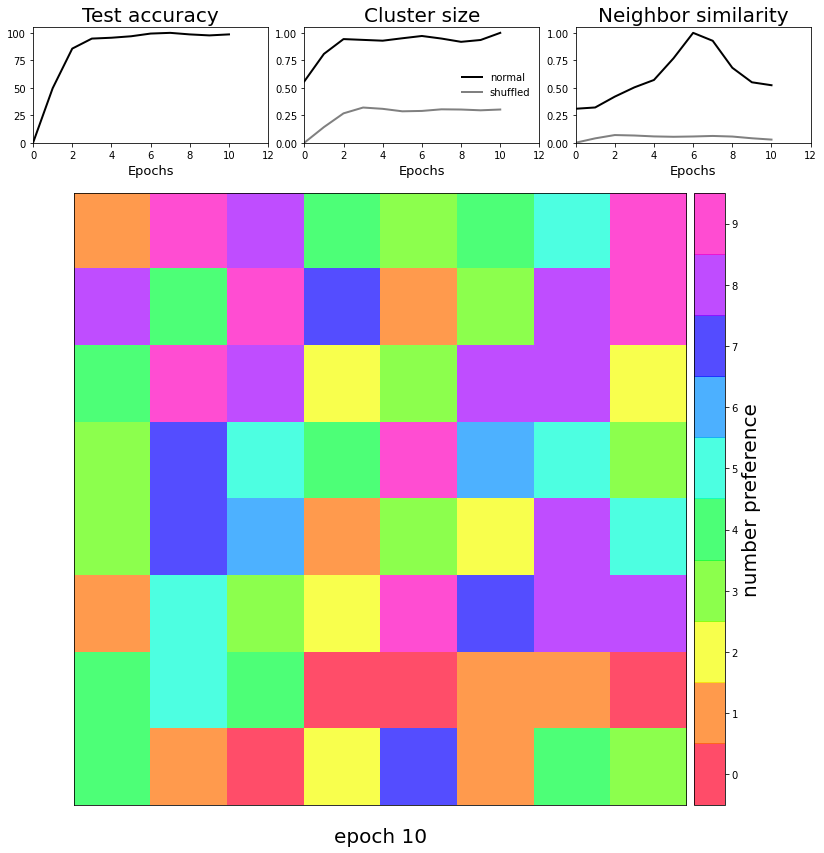

In [20]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
#modelnames = ['ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8']
#datasets = 4*['Numbers10']

modelnames = ['ResNet20']
datasets = ['MNIST']
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'];lc=len(classes)
threshold = 2
smoothing = 0
map_smoothing = 0.
nopref = True
for i, (modelname, dataset) in enumerate(zip(modelnames, datasets)): 
  compute_save_metrics2(modelname=modelname, dataset=dataset, T=threshold, S=smoothing, nopref=nopref)
  animate_numerosity(T=threshold, S_map = map_smoothing, nopref=nopref)


# Summary results

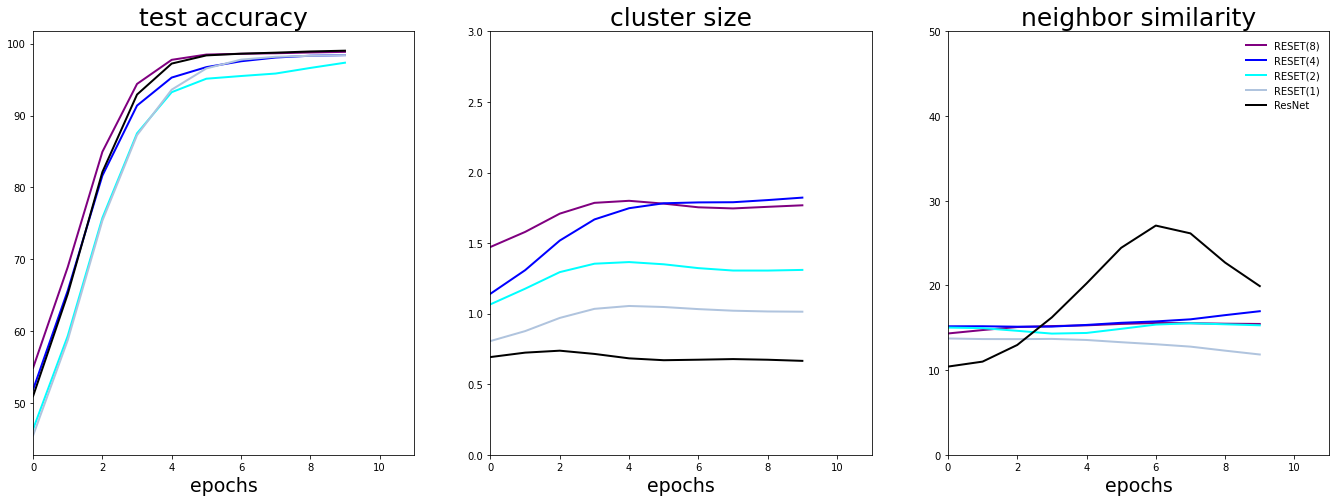

'done'

In [22]:
def plot_model_comparison(prefix='/content/drive/MyDrive/ColabNotebooks/', epoch=51):
    r=-1; smooth = 1.5
    epoch = 10
    models = ['ResNet20', 'ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8'][::-1]
    names = ['ResNet', 'RESET(1)', 'RESET(2)', 'RESET(4)', 'RESET(8)'][::-1]
    datasets = 5*['MNIST'][::-1]
    colors = ['black', 'lightsteelblue', 'cyan', 'blue', 'purple'][::-1]
    
    """
    models = ['ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8'][::-1]
    names = ['RESET(1)', 'RESET(2)', 'RESET(4)', 'RESET(8)'][::-1]
    datasets = 4*['Numbers10']
    colors = ['lightsteelblue', 'cyan', 'blue', 'purple'][::-1]
    """
    # initialize figure
    fig = plt.figure(figsize=(20, 7)) 
    ncols, nrows = 3, 1
    gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.08, right=0.95, top=0.92)#, wspace=2, hspace=10)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])

    stitle = 25
    slabels = 19
    #plt.suptitle(modelname+' '+dataset, size=25)
    ax0.set_title('test accuracy', size=stitle)
    ax0.set_xlabel('epochs', size=slabels) 
    ax0.set_xlim(0, epoch+1)
    #ax0.set_ylim(0, 0.5)
    
    #ax1.set_title('clustering index', size=20)
    ax1.set_title('cluster size', size=stitle)
    ax1.set_xlabel('epochs', size=slabels)
    ax1.set_xlim(0, epoch+1)
    ax1.set_ylim(0, 3.0)
    
    #ax2.set_title('density index', size=20)
    ax2.set_title('neighbor similarity', size=stitle)
    ax2.set_xlabel('epochs', size=slabels)
    ax2.set_xlim(0, epoch+1)
    ax2.set_ylim(0, 50.0)

    # load and preprocess data (smooth and normalize)
    for i, (model, name, dataset, color) in enumerate(zip(models, names, datasets, colors)):
      # load data
      los = np.load(prefix+model+dataset+'test_acc_history.npy')
      clu = np.load(prefix+model+dataset+'clustering_history.npy')-np.load(prefix+model+dataset+'clustering_history_ctrl.npy')
      topo = np.load(prefix+model+dataset+'topo_history.npy')-np.load(prefix+model+dataset+'topo_history_ctrl.npy')

      #los = np.median(los, axis=1)
      clu = np.median(clu, axis=1)
      topo = np.median(topo, axis=1)

      # smooth
      if smooth > 0:
          los = ndimage.gaussian_filter1d(los[:r], smooth, 0)
          clu = ndimage.gaussian_filter1d(clu[:r], smooth, 0)
          topo = ndimage.gaussian_filter1d(topo[:r], smooth, 0)
      
      # plot data as subplots in same figure
      ax0.plot(los, lw=2, label=name, c=color)
      ax1.plot(clu, lw=2, label=name, c=color)
      ax2.plot(topo, lw=2, label=name, c=color)

    plt.legend(frameon=False)
    plt.savefig('numerosity_comparison.png', dpi = 300)
    plt.show()
    
    return 'done'

plot_model_comparison()

# Conclusions

Is there topography for numbers ? <br>
Yes. In these networks:<br>
1. Units with the same number preference are more likely than chance to be connected on the map (quantified with clustering index).<br>
2. Units with similar number preferences cluster together on the map (quantified with neighborhood index).<br>
3. Clustering increases with the number of subnetworks. Subnetworks appear to specialize in different numbers.